# Task 1 (30 points): Decision Tree Classifier  
Implement a Decision Tree Classifier for your classification problem. You may use a built-in package to implement your classifier. Try modifying one or more of the input parameters and describe what changes you notice in your results. Clearly describe how these factors are affecting your output.

## Problem

My problem is going to be classifying which heuristics are fastest able to find a proof of a conjecture in first order logic based on statistical and dynamic information about the syntax of the premisses and conjecture. I.E. we will be creating a classifier to aid in the heuristic selection problem for automated theorem proving. 

## Dataset & Parsing

For my dataset I will be using the First Order Theorem Proving dataset provided by Bridge et al. at [https://archive.ics.uci.edu/ml/datasets/First-order+theorem+proving](https://archive.ics.uci.edu/ml/datasets/First-order+theorem+proving) and explained in the paper [Machine Learning for First-Order Theorem Proving](https://www.semanticscholar.org/paper/Machine-Learning-for-First-Order-Theorem-Proving-to-Bridge-Holden/19169c6de54bfb3b06a6a16e593cdf7ac1391209). 

In [2]:

#Imports
import pandas as pd
import numpy as np

#The feature list can be found in Tables 2 and 3 in the paper, 
#the first 14 are statistical features, the remaining are dynamic features
feature_names = [f"x_{i}" for i in range(51)]

#H1-H5 respectively correspond to heuristics 1-5 in the paper in Table 1.
heuristic_names = [f"H{x}" for x in range(1,6)]

#The final column indicates if a proof was found at all within reasonable time,
# we treat this as the 6th heuristic, H0
col_names = feature_names + heuristic_names + ["H0"] 

#The data is provided to us pre-split into train, test, and validation. 
#Since we will be doing k-fold validation later, we recombine it into a single dataframe. 
train_raw = pd.read_csv("./ml-prove/train.csv", names=col_names)
test_raw = pd.read_csv("./ml-prove/test.csv", names=col_names)
valid_raw = pd.read_csv("./ml-prove/validation.csv", names=col_names)
data_raw = pd.concat([train_raw, test_raw, valid_raw])
print(data_raw.shape)
data_raw.head()

(6118, 57)


,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,...,x_47,x_48,x_49,x_50,H1,H2,H3,H4,H5,H0
0,1.4895,0.81688,2.1168,1.7836,1.5346,-0.30543,-1.2477,-0.14537,-0.59356,-0.23316,...,-0.48278,1.4630,0.27015,-1.5559,-1,-1,-1,-1,-1,1
1,1.4895,0.81688,2.1168,1.7895,1.5403,-0.31850,-1.2477,-0.14537,-0.59356,-0.23316,...,-0.48278,1.4801,0.21361,-1.5559,1,-1,-1,-1,-1,-1
2,1.4895,0.81688,2.1168,1.7836,1.5346,-0.30543,-1.2477,-0.14537,-0.59356,-0.23316,...,-0.48278,1.4744,0.23245,-1.5559,-1,-1,-1,-1,-1,1
3,1.4895,0.81688,2.1168,1.7836,1.5346,-0.30543,-1.2477,-0.14537,-0.59356,-0.23316,...,-0.48278,1.4401,0.34553,-1.5559,-1,-1,-1,-1,-1,1
4,1.4895,0.81688,2.1168,1.7836,1.5346,-0.30543,-1.2477,-0.14537,-0.59356,-0.23316,...,-0.48278,1.4458,0.32669,-1.5559,-1,-1,-1,-1,-1,1


In [3]:
#Buckets the heuristics into a single class col with the heuristic label

from configparser import InterpolationSyntaxError


raw_copy = data_raw.copy()
heuristics = [f"H{i}" for i in range(6)]
for i,h in enumerate(heuristics):
    raw_copy[h] = (raw_copy[h] == 1).astype(int) * raw_copy[h] * i
raw_copy["H"] = raw_copy[heuristics].sum(axis=1)
raw_copy.drop(heuristics, axis=1, inplace=True)
data = raw_copy
data.head()

,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,...,x_42,x_43,x_44,x_45,x_46,x_47,x_48,x_49,x_50,H
0,1.4895,0.81688,2.1168,1.7836,1.5346,-0.30543,-1.2477,-0.14537,-0.59356,-0.23316,...,0.026975,1.8323,0.97743,2.6676,1.6803,-0.48278,1.4630,0.27015,-1.5559,0
1,1.4895,0.81688,2.1168,1.7895,1.5403,-0.31850,-1.2477,-0.14537,-0.59356,-0.23316,...,0.026975,1.8323,0.97743,2.6676,1.6974,-0.48278,1.4801,0.21361,-1.5559,1
2,1.4895,0.81688,2.1168,1.7836,1.5346,-0.30543,-1.2477,-0.14537,-0.59356,-0.23316,...,0.026975,1.8323,0.97743,2.6676,1.6917,-0.48278,1.4744,0.23245,-1.5559,0
3,1.4895,0.81688,2.1168,1.7836,1.5346,-0.30543,-1.2477,-0.14537,-0.59356,-0.23316,...,0.026975,1.8323,0.97743,2.6676,1.6575,-0.48278,1.4401,0.34553,-1.5559,0
4,1.4895,0.81688,2.1168,1.7836,1.5346,-0.30543,-1.2477,-0.14537,-0.59356,-0.23316,...,0.026975,1.8323,0.97743,2.6676,1.6632,-0.48278,1.4458,0.32669,-1.5559,0


## Analysis

We investigate the correlations of our features and heuristics as well as the ratios of heuristics that were found to be fastest. Our results show there is some minimal corelation between our heuristic and our

([<matplotlib.patches.Wedge at 0x1805b971e20>,
 [Text(0.28206298923703516, 1.0632217407966547, '0'),
  Text(-1.0990950212662474, -0.04461092049876686, '1'),
  Text(-0.6091885351868704, -0.9159090176414223, '3'),
  Text(0.12905276048629033, -1.0924034900213695, '5'),
  Text(0.7536932923576143, -0.80121558962313, '4'),
  Text(1.0659230395982722, -0.27167641350249794, '2')],
 [Text(0.15385253958383732, 0.5799391313436297, '41.7%'),
  Text(-0.5995063752361349, -0.024333229362963737, '17.8%'),
  Text(-0.33228465555647474, -0.4995867368953212, '12.2%'),
  Text(0.07039241481070381, -0.5958564491025652, '10.2%'),
  Text(0.4111054321950623, -0.43702668524898, '10.1%'),
  Text(0.581412567053603, -0.14818713463772612, '7.9%')])

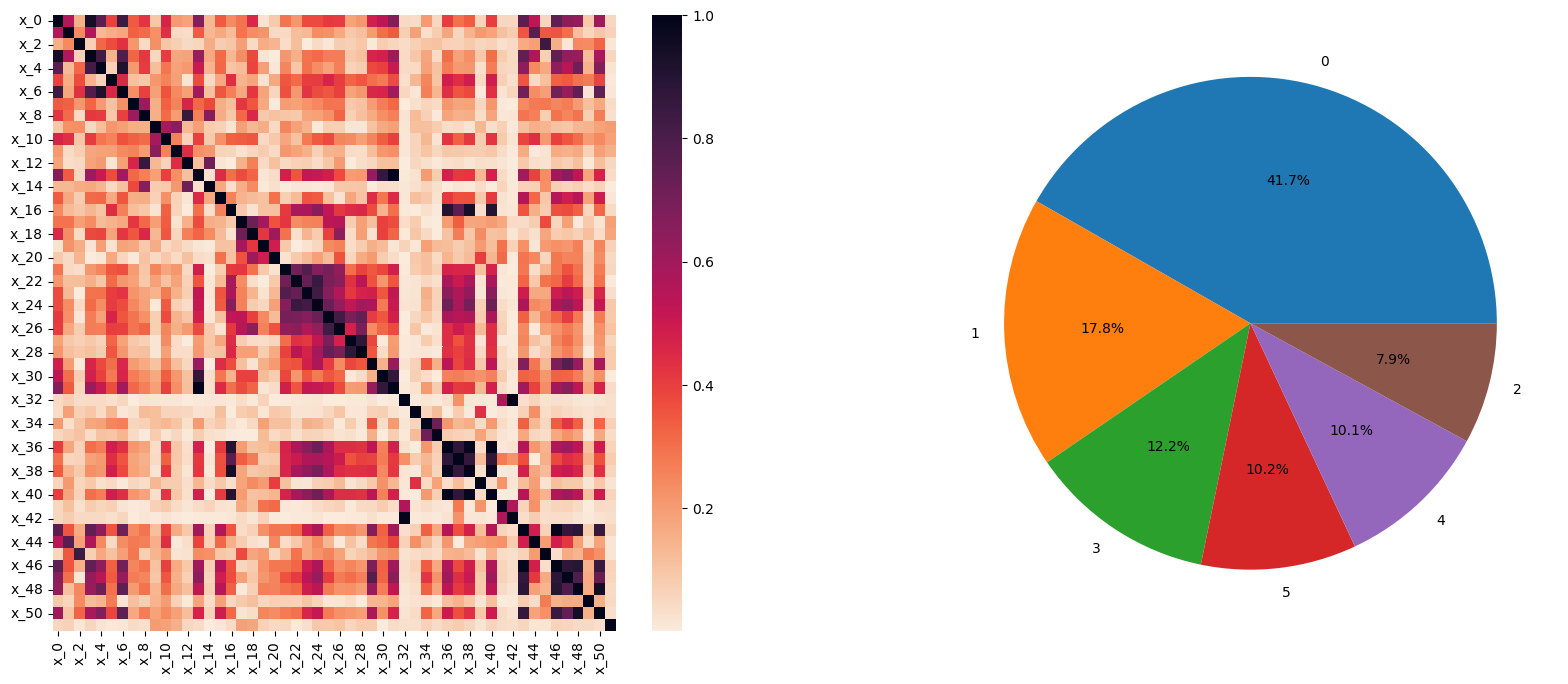

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(ncols=2, figsize=(20,8))
#ax[0].imshow(data_raw.corr().abs(), cmap='rocket_r')
sns.heatmap(data.corr().abs(),annot=False, ax=ax[0], cmap='rocket_r')
ax[1].pie(x=data["H"].value_counts(), labels=data["H"].value_counts().index, autopct='%1.1f%%')



## Decision Trees for the Problem

I investigate the performance of the scikitlearn decision tree on the problem at hand. I compare it's performance to a dummy classifier that always selects the class with the highest probability. The data is divided into a train an test set and evaluated with classification accuracy on the train set and test set. An interesting note here is that because I am predicting categorical output from continuous features in my problem, my implementation can't use the default attribute selection measures until after learning a threshold to split the continuous features into positive and negative classes, this is implemented internally in scikitlearn with the CART algorithm. Note that we don't display this default parameter tree because by default scikit learn has no max depth and the tree is too big to plot, we will instead print a smaller tree that preforms just as well after our hyperparameter investigation. 

In [5]:
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split

#print the accuracy on the train and test sets 
def score(model_name, model):
    print(model_name + " Train Accuracy Score: %.2f" % model.score(train[feature_names], train["H"]))
    print(model_name + " Test Accuracy Score:  %.2f" % model.score(test[feature_names], test["H"]))

#split the data into train and test sets
train, test = train_test_split(data, test_size=0.05)

#train and score a dummy classifier which returns the most frequent class label
dummy_model = DummyClassifier(strategy="prior")
dummy_model.fit(train[feature_names], train["H"])
score("Dummy", dummy_model)

#train and score a decision tree with default hyperparameters
default_decision_tree_model = DecisionTreeClassifier()
default_decision_tree_model.fit(train[feature_names], train["H"])
score("Default Decision Tree", default_decision_tree_model)


Dummy Train Accuracy Score: 0.42
Dummy Test Accuracy Score:  0.42
Default Decision Tree Train Accuracy Score: 0.98
Default Decision Tree Test Accuracy Score:  0.55


## Hyperparameter Investigation

Its rather clear that the decision tree with default hyperparameters greatly overfitted the training data, with ~98% accuracy on training data but only ~55% on the unseen test data. This issue is one of the things we would like to investigate remedying through a hyperparameter investigation of `max_depth`, `min_samples_split`, and `max_features` (Note that the `min_impurity_split` parameter we were told to look into investigating as well was depreciated). We train a few variants of the decision tree with single modified hyperparameters to see if we can minimize overfitting. 



In [6]:

parameter_names = ["max_depth", "min_samples_split", "max_features"]
parameter_values = {"max_depth" : range(1, 100, 5), "min_samples_split": range(2, 200, 10), "max_features" : range(2,50,5)}
train_accuracies = {key:[] for key in parameter_names}
test_accuracies = {key:[] for key in parameter_names}

for parameter_name in parameter_names:
    for parameter_value in parameter_values[parameter_name]:
        tree_model = DecisionTreeClassifier(**{parameter_name : parameter_value})
        tree_model.fit(train[feature_names], train["H"])
        train_accuracies[parameter_name].append(tree_model.score(train[feature_names], train["H"]))
        test_accuracies[parameter_name].append(tree_model.score(test[feature_names], test["H"]))

Text(0, 0.5, 'accuracy')

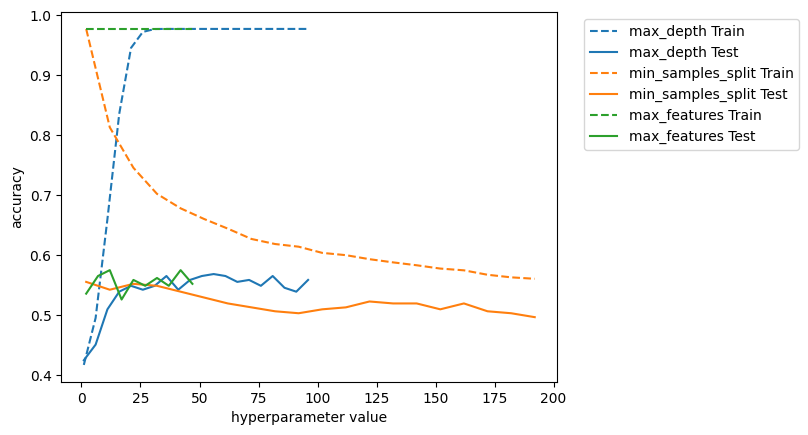

In [7]:
for parameter_name in parameter_names:
    trainLine = plt.plot(parameter_values[parameter_name], train_accuracies[parameter_name], label=parameter_name + " Train", ls="--")
    plt.plot(parameter_values[parameter_name], test_accuracies[parameter_name], label=parameter_name + " Test", color=trainLine[0].get_color())
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.xlabel("hyperparameter value")
plt.ylabel("accuracy")

The `max_depth` hyperparameter clearly has the biggest effect on our the tree's performance; with a tree of depth 1, the tree preforms on the same level as the dummy classifier. This theoretically makes sense since a decision tree with only a root node classifies everything the same class, which is the exact same behavior as the dummy classifier we selected. As `max_depth` increases, there is a great increase in the accuracy, for the training data, it climbs to near perfect by the time `max_depth`=20, for the testing data accuracy improvements level out around `max_depth`=16. `min_samples_split` combats overfitting, reducing the training accuracy as the number of samples required to split a node increases. This makes sense since as the number of samples required to split a node increases, the harder it is harder for smaller groups of outlying data points in the training data to split off of more general group and be correctly classified. Unfortunately this does not seem to improve our testing accuracy, which can be seen as a sign that the points being incorrectly classified in the test set are not being incorrectly classified because of the smaller groups of outlying data points which originally had their own nodes splitting off. `max_features` did not appear to have a significant effect on the model for this data. 

## Tree Visualization 
We use the hyperparameters discovered in our investigation to create a much smaller decision tree with the same performance as the default parameter decision tree with no depth limit and one sample per node.  

Optimized Decision Tree Train Accuracy Score: 0.60
Optimized Decision Tree Test Accuracy Score:  0.50


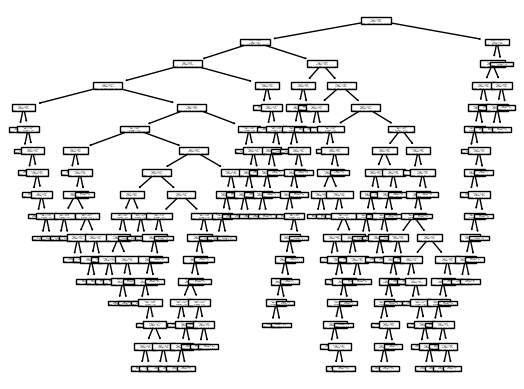

In [8]:
optimized_decision_tree_model = DecisionTreeClassifier(max_depth=16, min_samples_split=100)
optimized_decision_tree_model.fit(train[feature_names], train["H"])
score("Optimized Decision Tree", optimized_decision_tree_model)
plot_tree(optimized_decision_tree_model);


# Task 2 (30 points): Ensemble Methods

From the Bagging and Boosting ensemble methods pick any one algorithm from each category. Implement both the algorithms using the same data. Use k-fold cross validation to find the effectiveness of both the models. Comment on the difference/similarity of the results.

## Bagging

I implement a bagging classifier is designed in line with the bagging classifier used by [scikitlearn's BaggingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html). It also makes use of the sklearn API so that I may integrate it with sklearn's `cross_val_score` method for cross validation.

In [16]:

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample

class MyBaggingClassifier(BaseEstimator, ClassifierMixin): #custom sklearn estimator class
    def __init__(self):
        BaseEstimator.__init__(self)
        ClassifierMixin.__init__(self)

        #hyperparameters
        self.n_estimators = 10  #10 is also the default used by scikitlearn's BaggingClassifier
        
        #create our weak models for each bag
        self.models = [DecisionTreeClassifier() for _ in range(self.n_estimators)]

    def fit(self, X, y):
        #create and fill our data bags via bootstrapping 
        bags = []
        for _ in range(self.n_estimators):
            bags.append(resample(X, y, replace=True, n_samples=X.shape[0])) #sklearn BaggingClassifier will by default sample up to the original size X.shape[0]
        
        #train our weak individual decision tree classifiers 
        for bag, model in zip(bags, self.models):
            model.fit(*bag) 

        return self
    
    #use voting to determine which class our bagging model is the correct classification
    def predict(self, X):
        votes = []
        for model in self.models:
            votes.append(model.predict(X))
        
        #return the most frequently occurring label from our ensemble
        vote_matrix = np.c_[votes]
        rv = [] 
        for i in range(vote_matrix.shape[1]):
            rv.append(np.argmax(np.bincount(vote_matrix[:,i])))
        return np.array(rv)



To test my bagging classifier I use k-fold cross validation with 10 splits, I compare it against Scikit Learn's bagging classifier. 

In [17]:
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score

#using Use k-fold cross validation to test our bagging
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

In [18]:
my_model = MyBaggingClassifier()
my_model_scores = cross_val_score(my_model, X=data[feature_names], y=data["H"], scoring='accuracy', n_jobs=-1, cv=cv, error_score='raise')
print("My Bagging Classifier Accuracy: " + str(np.mean(my_model_scores)))

My Bagging Classifier Accuracy: 0.6121793088939521


In [19]:
#Test the performance of the built in skl BaggingClassifier on our data vs our classifier
from sklearn.ensemble import BaggingClassifier

skl_model = BaggingClassifier(n_estimators=10)
skl_model_scores = cross_val_score(skl_model, X=data[feature_names], y=data["H"], scoring='accuracy', cv=cv, error_score='raise')
print("Scikit Bagging Classifier Accuracy: " + str(np.mean(skl_model_scores)))

Scikit Bagging Classifier Accuracy: 0.6086392713113613


The results show that the bagging classifier consistently improves performance by about 5% over the base decision tree on this dataset.

## Boosting